In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
C, N = 5, 500 # number of classes and number of points per class
means = [[2, 2], [8, 3], [3, 6], [14, 2], [12, 8]]
cov = [[1, 0], [0, 1]]
np.random.seed(2)
X0 = torch.Tensor(np.random.multivariate_normal(means[0], cov, N))
X1 = torch.Tensor(np.random.multivariate_normal(means[1], cov, N))
X2 = torch.Tensor(np.random.multivariate_normal(means[2], cov, N))
X3 = torch.Tensor(np.random.multivariate_normal(means[3], cov, N))
X4 = torch.Tensor(np.random.multivariate_normal(means[4], cov, N))
X_train = torch.cat((X0, X1, X2, X3, X4), dim = 0) # each row is a datapoint
y_train = torch.asarray([0]*N + [1]*N + [2]*N+ [3]*N + [4]*N) # label

C, N_ = 5, 50
X0_ = torch.Tensor(np.random.multivariate_normal(means[0], cov, N_))
X1_ = torch.Tensor(np.random.multivariate_normal(means[1], cov, N_))
X2_ = torch.Tensor(np.random.multivariate_normal(means[2], cov, N_))
X3_ = torch.Tensor(np.random.multivariate_normal(means[3], cov, N_))
X4_ = torch.Tensor(np.random.multivariate_normal(means[4], cov, N_))
X_test = torch.cat((X0_, X1_, X2_, X3_, X4_), dim = 0) # each row is a datapoint
y_test = torch.asarray([0]*N_ + [1]*N_ + [2]*N_+ [3]*N_ + [4]*N_) # label

In [3]:
class CustomDataset(Dataset):
    def __init__(self, samples, labels, *args, **kwargs):
        super(CustomDataset, self).__init__(*args, **kwargs)
        self.input = samples
        self.target = labels
    def __getitem__(self, idx):
        return (self.input[idx], self.target[idx])
    def __len__(self):
        return len(self.input)

In [4]:
training_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
print('training data size:',len(training_data))
print('test data size:', len(test_data))

training data size: 2500
test data size: 250


In [5]:
ex, label = training_data[0]
print('label: {}, value: {}'.format(label,ex))

label: 0, value: tensor([1.5832, 1.9437])


In [6]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size)
for X, y in train_dataloader:
    print('Shape of X:', X.shape)
    print('Shape of y:', y.shape, y.dtype)
    break

Shape of X: torch.Size([64, 2])
Shape of y: torch.Size([64]) torch.int64


In [7]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 5),
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
net = MyNet()
print(net)

MyNet(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=5, bias=True)
  )
)


In [8]:
def train_epoch(net, dataloader, lr = 0.01, optimizer = None, loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
    net.train()
    total_loss, acc, count = 0, 0, 0
    for features, labels in dataloader:
        # Compute prediction error
        pred = net(features)
        loss = loss_fn(pred, labels)
        
        # Backpropagagion
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        predicted = torch.argmax(pred, dim = 1)
        acc += (predicted == labels).sum()
        count += len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader, loss_fn = nn.NLLLoss()):
    net.eval()
    count, acc, loss = 0, 0, 0
    with torch.no_grad():
        for features, labels in dataloader:
            pred = net(features)
            loss += loss_fn(pred, labels)
            pred = torch.argmax(pred, dim = 1)
            acc += (pred==labels).sum()
            count += len(labels)
        return loss.item()/count, acc.item()/count
    
def train(net, train_loader, test_loader, optimizer = None, lr = 0.01, epochs = 10, loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
    res = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer = optimizer, lr = lr, loss_fn = loss_fn)
        vl, va = validate(net, test_loader, loss_fn = loss_fn)
        print(f'Epoch {ep:2}, Train acc = {ta:.3f}, Val acc = {va:.3f}, Train loss = {tl:.3f}, Val loss = {vl:.3f}')
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [9]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.05
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)

In [10]:
hist = train(net, train_dataloader, test_dataloader, optimizer = optimizer, lr = learning_rate, epochs = 10, loss_fn = loss_fn)

Epoch  0, Train acc = 0.654, Val acc = 0.792, Train loss = 0.024, Val loss = 0.009
Epoch  1, Train acc = 0.856, Val acc = 0.700, Train loss = 0.007, Val loss = 0.013
Epoch  2, Train acc = 0.880, Val acc = 0.552, Train loss = 0.006, Val loss = 0.030
Epoch  3, Train acc = 0.911, Val acc = 0.936, Train loss = 0.005, Val loss = 0.004
Epoch  4, Train acc = 0.927, Val acc = 0.896, Train loss = 0.004, Val loss = 0.004
Epoch  5, Train acc = 0.940, Val acc = 0.916, Train loss = 0.003, Val loss = 0.004
Epoch  6, Train acc = 0.939, Val acc = 0.688, Train loss = 0.003, Val loss = 0.023
Epoch  7, Train acc = 0.940, Val acc = 0.948, Train loss = 0.003, Val loss = 0.003
Epoch  8, Train acc = 0.954, Val acc = 0.948, Train loss = 0.003, Val loss = 0.002
Epoch  9, Train acc = 0.958, Val acc = 0.952, Train loss = 0.002, Val loss = 0.003


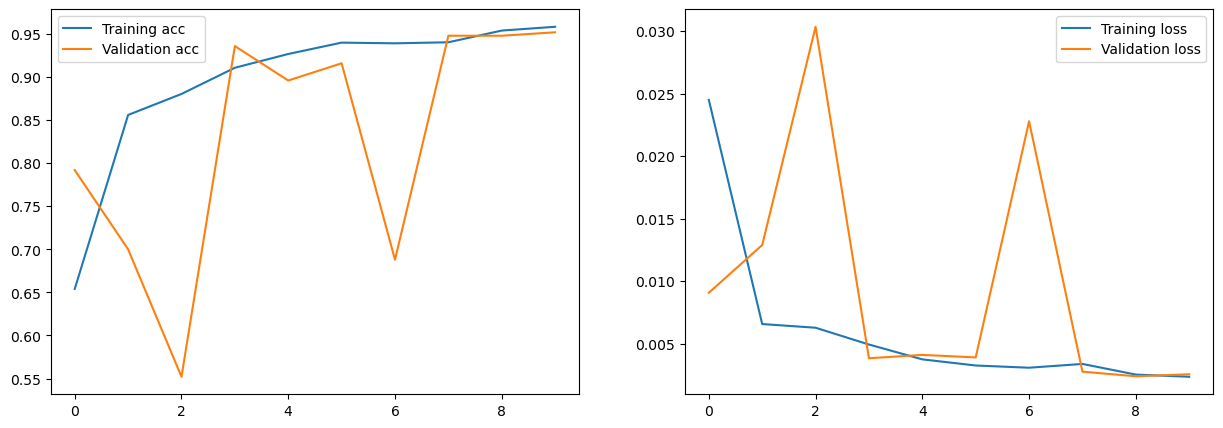

In [11]:
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label = 'Training acc')
plt.plot(hist['val_acc'], label = 'Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label = 'Training loss')
plt.plot(hist['val_loss'], label = 'Validation loss')
plt.legend()
plt.savefig('lec2_pactice_1_test.pdf', bbox_inches = 'tight')

In [12]:
def predict(model, X):
    out = model(X)
    pred = torch.argmax(out, dim = 1)
    return pred

C:\Users\admin\miniconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


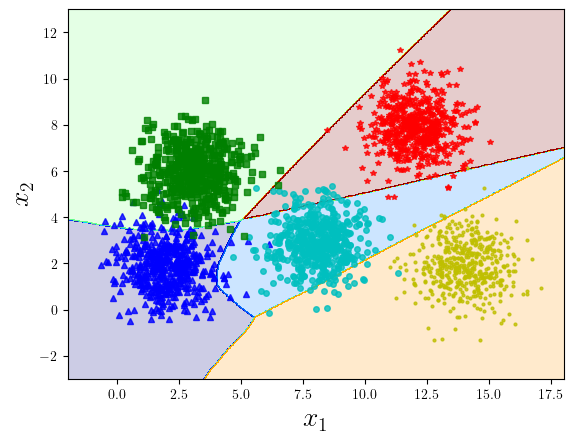

In [13]:
from matplotlib import rc
rc('text', usetex=True)

plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
plt.plot(X1[:, 0], X1[:, 1], 'co', markersize = 4, alpha = .8)
plt.plot(X2[:, 0], X2[:, 1], 'gs', markersize = 4, alpha = .8)
plt.plot(X3[:, 0], X3[:, 1], 'y.', markersize = 4, alpha = .8)
plt.plot(X4[:, 0], X4[:, 1], 'r*', markersize = 4, alpha = .8)
xx = torch.linspace(-2,18,500)
yy = torch.linspace(-3,13,500)
XX, YY = torch.meshgrid(xx, yy)
xx1 = XX.flatten().reshape(-1,1)
yy1 = YY.flatten().reshape(-1,1)

XX1 = torch.cat((xx1, yy1), dim = 1)




net.eval()
with torch.no_grad():
    Z = predict(net, XX1)
    plt.contourf(XX,YY,Z.reshape(XX.shape), 200, cmap = 'jet', alpha = 0.2)
    plt.xlabel('$x_1$', fontsize = 20)
    plt.ylabel('$x_2$', fontsize = 20)
    plt.savefig('softmax_test.pdf', bbox_inches = 'tight')

## Another example

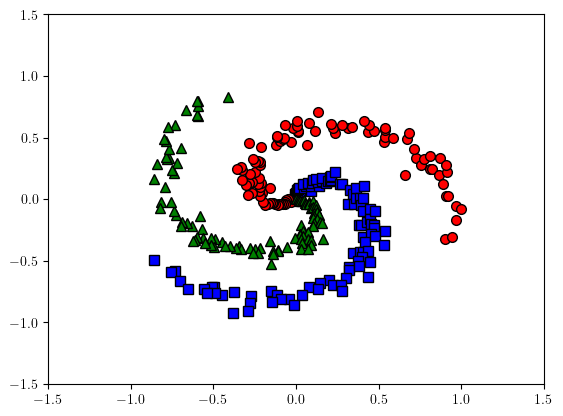

In [14]:
N = 100 # number of points per class
d0 = 2 # dimensionality
C = 3 # number of classes
X = np.zeros((N*C, d0)) # data matrix (each row = single example)
y = np.zeros(N*C, dtype='uint8') # class labels
np.random.seed(2)

# make test data
X_ = np.zeros((N*C, d0)) # data matrix (each row = single example)
y_ = np.zeros(N*C, dtype='uint8') # class labels

for j in range(C):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
    X_[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y_[ix] = j
# lets visualize the data:
# plt.scatter(X[:N, 0], X[:N, 1], c=y[:N], s=40, cmap=plt.cm.Spectral)

plt.plot(X[:N, 0], X[:N, 1], 'bs', markersize = 7, markeredgecolor = 'k');
plt.plot(X[N:2*N, 0], X[N:2*N, 1], 'ro', markersize = 7, markeredgecolor = 'k');
plt.plot(X[2*N:, 0], X[2*N:3*N:, 1], 'g^', markersize = 7, markeredgecolor = 'k');

#plt.plot(X[2*N:3*N, 0], X[2*N:3*N:, 1], 'g^', markersize = 7, markeredgecolor = 'k');
#plt.plot(X[3*N:4*N, 0], X[3*N:4*N, 1], 'yo', markersize = 7, markeredgecolor = 'k');
#plt.plot(X[4*N:, 0], X[4*N:, 1], '^', color = 'orange', markersize = 7, markeredgecolor = 'k');

# plt.axis('off')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
# machinelearningcoban.com
plt.savefig('tornado.pdf', bbox_inches = 'tight')

In [15]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y)
X_ = torch.from_numpy(X_).type(torch.float32)
y_ = torch.from_numpy(y_)
training_data2 = CustomDataset(X, y)
test_data2 = CustomDataset(X_, y_)
print('training data size:',len(training_data2))
print('test data size:', len(test_data2))

training data size: 300
test data size: 300


In [16]:
ex, label = training_data2[0]
print('label: {}, value: {}'.format(label,ex))

label: 0, value: tensor([-0., 0.])


In [17]:
batch_size2 = 5
train_dataloader2 = DataLoader(training_data2, batch_size = batch_size2, shuffle = True)
test_dataloader2 = DataLoader(test_data2, batch_size = batch_size2)
for Xt, yt in train_dataloader2:
    print('Shape of X:', X.shape)
    print('Shape of y:', y.shape, y.dtype)
    break

Shape of X: torch.Size([300, 2])
Shape of y: torch.Size([300]) torch.uint8


In [18]:
net2 = MyNet()
print(net2)

MyNet(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=5, bias=True)
  )
)


In [19]:
loss_fn2 = nn.CrossEntropyLoss()
learning_rate2 = 0.05
optimizer2 = torch.optim.SGD(net2.parameters(), lr = learning_rate2)

In [20]:
hist2 = train(net2, train_dataloader2, test_dataloader2, optimizer = optimizer2, lr = learning_rate2, epochs = 10, loss_fn = loss_fn2)

Epoch  0, Train acc = 0.523, Val acc = 0.513, Train loss = 0.211, Val loss = 0.172
Epoch  1, Train acc = 0.583, Val acc = 0.543, Train loss = 0.166, Val loss = 0.158
Epoch  2, Train acc = 0.550, Val acc = 0.543, Train loss = 0.158, Val loss = 0.152
Epoch  3, Train acc = 0.547, Val acc = 0.577, Train loss = 0.152, Val loss = 0.154
Epoch  4, Train acc = 0.537, Val acc = 0.540, Train loss = 0.151, Val loss = 0.145
Epoch  5, Train acc = 0.587, Val acc = 0.553, Train loss = 0.147, Val loss = 0.143
Epoch  6, Train acc = 0.550, Val acc = 0.550, Train loss = 0.146, Val loss = 0.140
Epoch  7, Train acc = 0.573, Val acc = 0.580, Train loss = 0.143, Val loss = 0.142
Epoch  8, Train acc = 0.587, Val acc = 0.557, Train loss = 0.142, Val loss = 0.135
Epoch  9, Train acc = 0.593, Val acc = 0.630, Train loss = 0.137, Val loss = 0.137


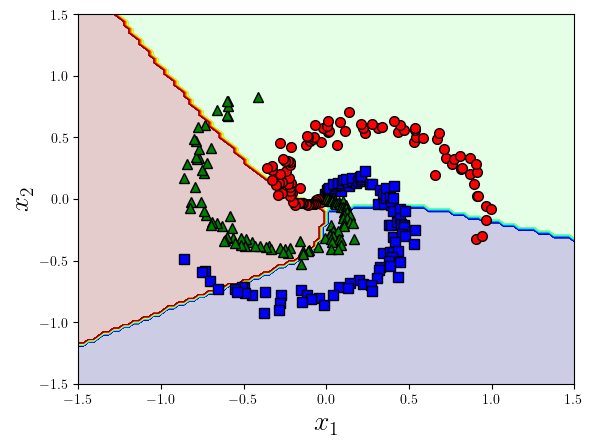

In [21]:
from matplotlib import rc
rc('text', usetex=True)

plt.plot(X[:N, 0], X[:N, 1], 'bs', markersize = 7, markeredgecolor = 'k');
plt.plot(X[N:2*N, 0], X[N:2*N, 1], 'ro', markersize = 7, markeredgecolor = 'k');
plt.plot(X[2*N:, 0], X[2*N:, 1], 'g^', markersize = 7, markeredgecolor = 'k');

xx = torch.linspace(-1.5, 1.5, 100)
yy = torch.linspace(-1.5, 1.5, 100)
XX, YY = torch.meshgrid(xx, yy)
xx1 = XX.flatten().reshape(-1,1)
yy1 = YY.flatten().reshape(-1,1)

XX1 = torch.cat((xx1, yy1), dim = 1)




net.eval()
with torch.no_grad():
    Z = predict(net2, XX1)
    plt.contourf(XX,YY,Z.reshape(XX.shape), 200, cmap = 'jet', alpha = 0.2)
    plt.xlabel('$x_1$', fontsize = 20)
    plt.ylabel('$x_2$', fontsize = 20)
    plt.savefig('softmax2_test.pdf', bbox_inches = 'tight')

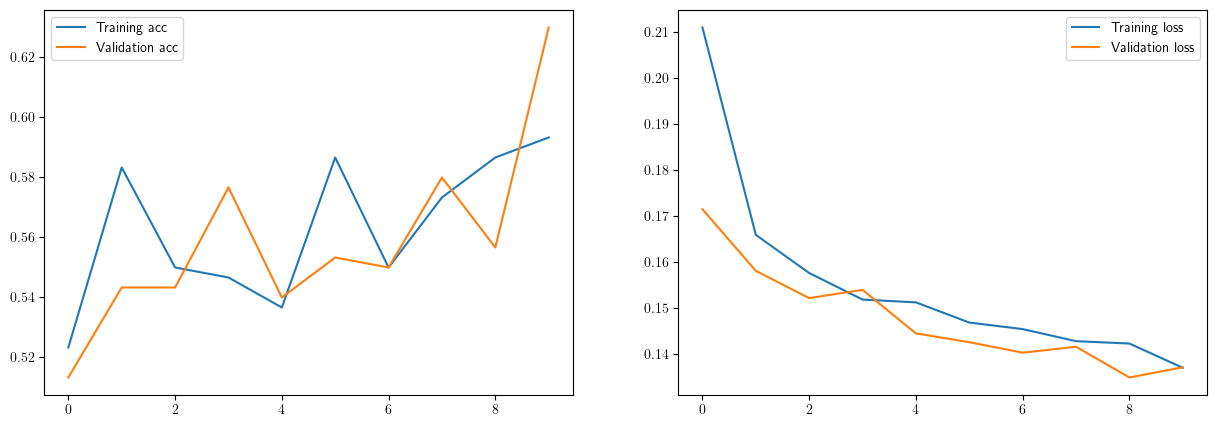

In [22]:
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.plot(hist2['train_acc'], label = 'Training acc')
plt.plot(hist2['val_acc'], label = 'Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist2['train_loss'], label = 'Training loss')
plt.plot(hist2['val_loss'], label = 'Validation loss')
plt.legend()
plt.savefig('lec2_pactice_2_test.pdf', bbox_inches = 'tight')